In [1]:
import pandas as pd
import numpy as np
import re

from torch import nn
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import *
import torchvision.models as models


import torch.nn as nn
from transformers import BertModel
from transformers import BertTokenizer
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util

nltk.download('stopwords')

/home/vscode/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load data

In [2]:
training_images_path = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images'
training_dataset =pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train.csv')
testing_dataset = pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/test.csv')

### Process titles (remove punctuation, stop words, etc)

In [3]:
# remove stop words 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# remove punctuation
import string
punctuations = string.punctuation

# remove numbers
import re
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

# remove special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

# remove extra spaces
def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text)
    return text

def word_tokenize(text):
    text = text.split()
    return text

# remove stop words
def remove_stop_words(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stop_words]
    filtered_sentence = (" ").join(tokens_without_sw)
    return filtered_sentence

# remove all preprocessing
def remove_all_preprocessing(text):
    text = remove_numbers(text)
    text = remove_special_characters(text)
    text = remove_extra_spaces(text)
    text = remove_stop_words(text)
    return text

# apply all preprocessing
training_dataset['title'] = training_dataset['title'].apply(lambda x: remove_all_preprocessing(x))
testing_dataset['title'] = testing_dataset['title'].apply(lambda x: remove_all_preprocessing(x))

# get rid of \
training_dataset['title'] = training_dataset['title'].apply(lambda x: x.replace('\\', ''))
# lower case
training_dataset['title'] = training_dataset['title'].apply(lambda x: x.lower())

### Experiment with base BERT model

In [4]:
from transformers import BertTokenizer, TFBertModel
from tqdm import tqdm

model_name='cahya/bert-base-indonesian-522M'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)

bert_title_vectors = np.zeros((training_dataset.shape[0],768))

for idx,txt in tqdm(enumerate(training_dataset['title'])):
  encoded_input = tokenizer(txt, return_tensors='tf')
  output = model(encoded_input)
  bert_title_vectors[idx]= output['pooler_output']

2023-04-15 19:35:46.590965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 19:35:50.916083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-15 19:35:53.804918: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Some layers from the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initiali

KeyboardInterrupt: 

In [ ]:
from transformers import BertTokenizer, TFBertModel
from tqdm import tqdm
import tensorflow as tf
import numpy as np

max_length = 128
num_classes = 10
model_name='cahya/bert-base-indonesian-522M'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)

input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Define the model architecture
embedding_layer = model(input_ids, attention_mask=attention_mask)[0]
pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
batch_norm_layer = tf.keras.layers.BatchNormalization()(pooling_layer)
dense_layer = tf.keras.layers.Dense(256, activation='relu')(batch_norm_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(dense_layer)
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout_layer)

model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output_layer)

bert_title_vectors = np.zeros((training_dataset.shape[0], 768))

for idx, txt in tqdm(enumerate(training_dataset['title'])):
    encoded_input = tokenizer(txt, return_tensors='tf', max_length=max_length, padding='max_length', truncation=True)
    output = model(encoded_input)
    bert_title_vectors[idx] = output[0][0].numpy()


Some layers from the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cahya/bert-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
0it [00:00, ?it/s]


ValueError: Layer "model_6" expects 2 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>, <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[    3, 20185,  1632,  8476, 12395,     1,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2]], dtype=int32)>, <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>]

### Check encoding from Advanced BERT model

In [5]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
embeddings = model.encode(training_dataset['title'])
print(embeddings)

[[-0.05237605  0.00266704 -0.0351623  ... -0.0220446   0.03120822
   0.0482746 ]
 [ 0.03168393  0.0207246  -0.01772413 ... -0.02363313  0.00672482
  -0.06600535]
 [-0.02553968  0.02782196  0.01990272 ... -0.0465625  -0.01983832
   0.01210797]
 ...
 [-0.00043891  0.0663081  -0.00434749 ...  0.04577914  0.02965026
  -0.03386611]
 [-0.02243138  0.02246639  0.05454137 ...  0.01867248  0.01682098
   0.00408043]
 [-0.03517014  0.02272914  0.00684843 ... -0.00679976 -0.01856173
  -0.00943737]]


##### Add layers to BERT

In [6]:
from sklearn.neighbors import NearestNeighbors


In [7]:
from torch.nn import Transformer


In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [9]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model.fit(embeddings, training_dataset['label_group'])

KNeighborsClassifier(weights='distance')

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
labels = training_dataset['label_group']


In [12]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)


In [29]:
from sklearn.metrics import accuracy_score, f1_score
acc_dict = {}
for k in [1, 2, 3, 5, 10, 25, 50, 100]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Evaluate the performance on the test set
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"k = {k}, Accuracy: {accuracy}")
    print(f"k = {k}, f1: {f1}")
    acc_dict[k] = accuracy

k = 1, Accuracy: 0.498978102189781
k = 1, f1: 0.4807792604732177
k = 2, Accuracy: 0.38306569343065694
k = 2, f1: 0.35805505780994695
k = 3, Accuracy: 0.3375182481751825
k = 3, f1: 0.31057035183397974
k = 5, Accuracy: 0.3005839416058394
k = 5, f1: 0.2676876029260309
k = 10, Accuracy: 0.24744525547445256
k = 10, f1: 0.20623973530342002
k = 25, Accuracy: 0.194014598540146
k = 25, f1: 0.14738019756662057
k = 50, Accuracy: 0.16583941605839417
k = 50, f1: 0.11615758877312352
k = 100, Accuracy: 0.13605839416058393
k = 100, f1: 0.08739168649665359


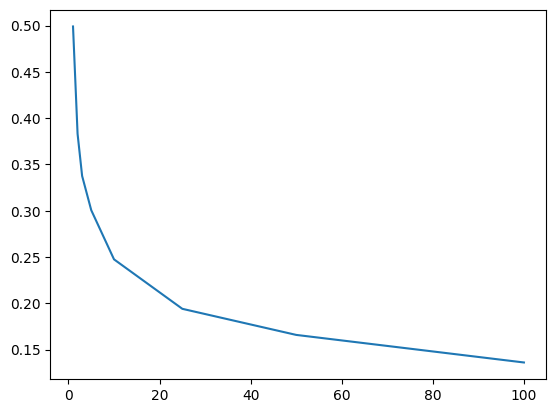

In [30]:
plt.plot(acc_dict.keys(), acc_dict.values())

In [23]:
from sklearn.metrics import accuracy_score, f1_score

In [24]:
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1 score:", f1)

Accuracy: 0.38306569343065694
F1 score: 0.35805505780994695


In [ ]:
from sentence_transformers import SentenceTransformer
model_name = 'sentence-transformers/distiluse-base-multilingual-cased-v2'

word_embedding_model = models.Transformer('sentence-transformers/distiluse-base-multilingual-cased-v2', max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=256, activation_function=nn.Tanh())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

#Our sentences we like to encode
# sentences = ['This framework generates embeddings for each input sentence',
#     'Sentences are passed as a list of string.',
#     'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(training_dataset.title)

#Print the embeddings
for sentence, embedding in zip(training_dataset.title, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")
    break

AttributeError: module 'torchvision.models' has no attribute 'Transformer'